In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from cmocean import cm
from scipy.interpolate import interp1d
from scipy import signal

In [2]:
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['font.size'] = 10

In [3]:
# Create nicer dimensions
def load_data(ncfile,datavar='ssh'):
    ds = xr.open_dataset(ncfile)
    dx = 4.0
    if len(ds['{}_lof'.format(datavar)].dims)==4:
        tdim, zdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    else:
        tdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    x = ds[xdim].values*dx
    y = ds[ydim].values*dx

    t0 = np.datetime64('1950-01-01 00:00:00')
    tdays = (ds.time_centered.values - t0).astype(float)*1e-9/86400.
    print(ncfile, tdays[0], tdays[-1])
    return xr.Dataset(
        {'{}_lof'.format(datavar):
            xr.DataArray(ds['{}_lof'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_cos'.format(datavar):
            xr.DataArray(ds['{}_cos'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_sin'.format(datavar):
            xr.DataArray(ds['{}_sin'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
        })

def load_scenario(scenario):
    ncfiles = {'wp50':
             [
             '../DATA/ROMS/wp5/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp5/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010220-00010410.nc'
             ],
               'wp60':
             [
             '../DATA/ROMS/wp6/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp6/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp6/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp6/t2/inst_00010220-00010410.nc',
             ],
               'wp75':
             [
             '../DATA/ROMS/wp75/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp75/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp75/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp75/t2/inst_00010220-00010410.nc',
             ],
                'wp80':
             [
             '../DATA/ROMS/wp8/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp8/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010220-00010410.nc'
             ],
               'wp90':
             [
             '../DATA/ROMS/wp9/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp9/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010220-00010410.nc'
             ],
              }
    
    ds0 = xr.open_mfdataset(ncfiles[scenario][0:2])
    ds1 = xr.open_mfdataset(ncfiles[scenario][2:4])
    
    dt1 = ds0['time_instant'][-1]-ds0['time_instant'][0]
    ds1['time_instant'] = ds1['time_instant']+dt1
    ds1['time_counter'] = ds1['time_counter']+dt1

    if len(ncfiles[scenario])>4:
        ds2 = xr.open_mfdataset(ncfiles[scenario][4:6])
        dt2 = ds1['time_instant'][-1]-ds1['time_instant'][0]
        
        ds2['time_instant'] = ds2['time_instant']+dt1+dt2
        ds2['time_counter'] = ds2['time_counter']+dt1+dt2

        return xr.concat([ds0, ds1, ds2], dim='time_counter')

    else:
        return xr.concat([ds0, ds1], dim='time_counter')
        

In [4]:
basedir = '../../SouthernOceanIWaves/DATA/'
scenario = 'wp75'


ds_v = xr.concat([load_data(ff, datavar='v_xy') for ff in glob('{}/{}-t*.nc'.format(basedir,scenario))], dim='time')
ds_u = xr.concat([load_data(ff, datavar='u_xy') for ff in glob('{}/{}-t*.nc'.format(basedir,scenario))], dim='time')
ds_ssh = xr.concat([load_data(ff, datavar='ssh') for ff in glob('{}/{}-t*.nc'.format(basedir,scenario))], dim='time')

nt =  ds_ssh.time.shape[0]
dt=2
ds_ssh['time']= np.arange(0, nt*dt,dt)
ds_u['time']= np.arange(0, nt*dt,dt)
ds_v['time']= np.arange(0, nt*dt,dt)


ds_ssh

../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t1.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t2.nc 1.0 99.0
../../SouthernOceanIWaves/DATA/wp75-t3.nc 1.0 99.0


<xarray.Dataset>
Dimensions:  (x: 258, y: 722, time: 150)
Coordinates:
  * x        (x) float64 0.0 4.0 8.0 12.0 ... 1.02e+03 1.024e+03 1.028e+03
  * y        (y) float64 0.0 4.0 8.0 12.0 ... 2.876e+03 2.88e+03 2.884e+03
  * time     (time) int64 0 2 4 6 8 10 12 14 ... 284 286 288 290 292 294 296 298
Data variables:
    ssh_lof  (time, y, x) float32 0.5852 0.5852 0.5852 ... -0.5846 -0.5846
    ssh_cos  (time, y, x) float32 1.362e-06 1.366e-06 ... 0.0003126 0.0003493
    ssh_sin  (time, y, x) float32 2.771e-06 2.786e-06 ... 0.0004348 0.0003556

/tmp/ipykernel_2550898/2958502343.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


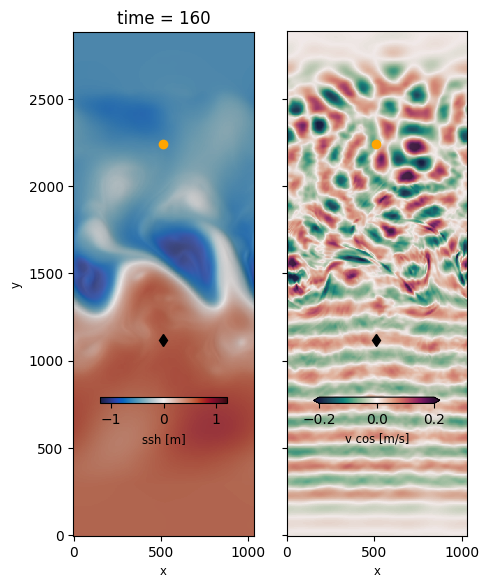

In [5]:
def initplot(ax1,ax2,tstep=0):
    #fig = plt.figure(figsize=(8,10), dpi=90)
    #ax1=plt.subplot(121)
    cbar_kwargs={'shrink':0.7,"orientation":'horizontal',"pad":-0.2}
    #bar_kwargs={'shrink':0.1,}
    ds_ssh['ssh_lof'].attrs['long_name']='ssh'
    ds_ssh['ssh_lof'].attrs['units']='m'
    c1=ds_ssh['ssh_lof'][tstep,...].plot(ax=ax1,vmin=-1.2, vmax=1.2, cmap=cm.balance, 
                                        cbar_kwargs=cbar_kwargs)

    ds_v['v_xy_lof'].attrs['long_name']='v'
    c2=ds_v['v_xy_lof'][tstep,...].plot(ax=ax1,cmap='gist_gray', alpha=0.25, add_colorbar=False)
    ax1.set_aspect('equal')

    #ax2=plt.subplot(122)
    #amp = np.abs( ds_v['v_xy_cos'][tstep,...] +1j * ds_v['v_xy_sin'][tstep,...])
    #c3=amp.plot(vmin=0, vmax=0.2, cmap=cm.speed, cbar_kwargs={'shrink':0.5})
    ds_v['v_xy_cos'].attrs['long_name']='v cos'
    c3=ds_v['v_xy_cos'][tstep,...].plot(ax=ax2,vmin=-0.2, vmax=0.2, cmap=cm.curl, 
                            cbar_kwargs=cbar_kwargs)
    c4= ds_ssh['ssh_cos'][tstep,...].plot(ax=ax2,cmap='gist_gray', alpha=0.1, add_colorbar=False)
    ax2.set_aspect('equal')
    ax2.set_title('')
    plt.tight_layout()
    return fig, ax1, ax2, c1, c2, c3, c4

y1,y2 = 280, 560
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5,8))
fig, ax1, ax2, c1, c2, c3, c4 = initplot(ax1, ax2,tstep=80, )
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][y1],'kd')
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][y2],'orange',marker='o')

ax2.plot(ds_ssh['x'][128], ds_ssh['y'][y1],'kd')
ax2.plot(ds_ssh['x'][128], ds_ssh['y'][y2],'orange',marker='o')
ax2.set_yticklabels([])
ax2.set_ylabel('')
plt.tight_layout()
# plt.savefig('../FIGURES/PK2015_snapshot_{}.png'.format(scenario), dpi=150)

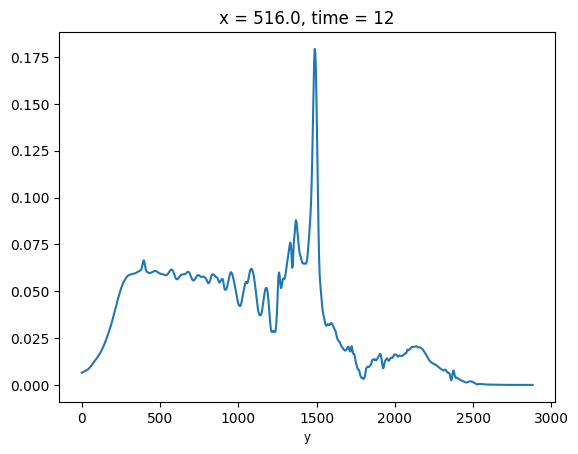

In [20]:
tt=6
np.abs(ds_v['v_xy_cos'][tt,:,258//2] + 1j*ds_v['v_xy_sin'][tt,:,258//2]).plot()

In [169]:
ds = load_scenario(scenario)


In [170]:
ds_vt = ds['v_y'].isel(y_vy=[y1,y2], x_vy=0, s_rho_slice0=0, time_counter=slice(1000,None)).load()
ds_vt

<xarray.DataArray 'v_y' (time_counter: 8600, y_vy: 2)>
array([[-0.2530767 , -0.16937108],
       [-0.24034399, -0.18101795],
       [-0.22568281, -0.1867989 ],
       ...,
       [-0.19500023,  0.17192453],
       [-0.16158664,  0.09295933],
       [-0.12770543,  0.01170153]], dtype=float32)
Coordinates:
    s_rho_slice0  float32 -0.01
    nav_lat_vy    (y_vy) float32 1.12e+06 2.24e+06
    nav_lon_vy    (y_vy) float32 5.1e+05 5.1e+05
    time_instant  (time_counter) datetime64[ns] 1979-01-21T20:30:00 ... 1979-...
  * time_counter  (time_counter) datetime64[ns] 1979-01-21T20:30:00 ... 1979-...
Dimensions without coordinates: y_vy
Attributes:
    long_name:           v-momentum component
    units:               meter second-1
    online_operation:    instant
    interval_operation:  1800 s
    interval_write:      1800 s
    cell_methods:        time: point

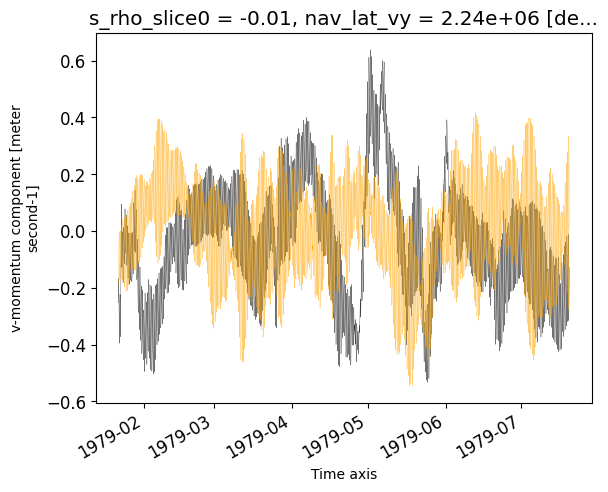

In [171]:
ds_vt.isel(y_vy=0).plot(c='k',lw=0.2)
ds_vt.isel(y_vy=1).plot(c='orange',lw=0.2)


In [172]:
import speccy
import nonstat_itides_jax as nsjax
import nonstat_itides as nsit
import optax

(1e-07, 10.0)

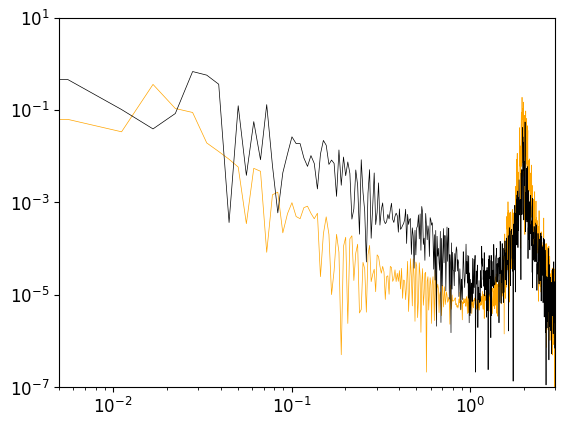

In [173]:


###
def plot_psd(ypr, ax, **kwargs):
    t_ = ypr['time_instant'] - ypr['time_instant'][0]
    t = t_.values.astype(float)/1e9/86400
    dt = ypr['time_instant'][1] - ypr['time_instant'][0]
    dtout = dt.values.astype(float)/1e9/86400
    
    y_coherent,_,_,_,_ = nsit.calc_coherent(ypr, t)

    #window=np.hanning(ypr.shape[0])
    window=None
    f, I =  speccy.periodogram(ypr-y_coherent[:,0], delta=dtout, h=window)
    
    ax.loglog(f, I, **kwargs)

fig,ax=plt.subplots(1,1)
plot_psd(ds_vt.isel(y_vy=1), ax, c='orange', lw=0.5)
plot_psd(ds_vt.isel(y_vy=0), ax, c='k', lw=0.5)
ax.set_xlim(5e-3, 3)
# ax.set_xlim(1.4, 2.6)
# ax.set_xscale('linear')
ax.set_ylim(1e-7, 1e1)

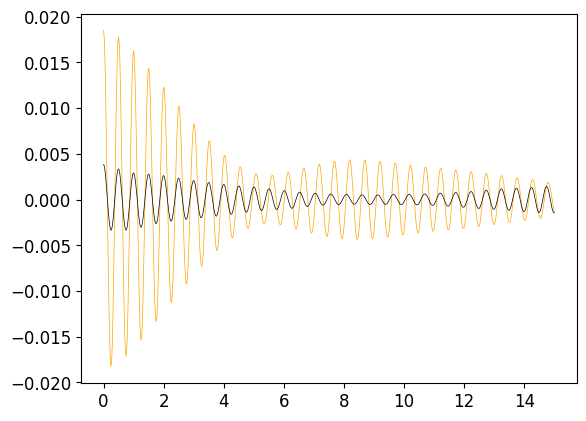

In [174]:
from statsmodels.tsa import stattools
from utils import filt_decompose

def plot_acf(ypr, ax, **kwargs):
    t_ = ypr['time_instant'] - ypr['time_instant'][0]
    t = t_.values.astype(float)/1e9/86400
    dt = ypr['time_instant'][1] - ypr['time_instant'][0]
    dtout = dt.values.astype(float)/1e9/86400
    
    y_coherent,_,_,_,_ = nsit.calc_coherent(ypr, t)
    y = ypr-y_coherent[:,0]

    yf = filt_decompose(y, dtout*86400)
    
    ndays=15.0
    tau = np.linspace(0.,ndays, int(1/dtout*ndays+1))
    acf = stattools.acovf( yf[:,1], nlag=1/dtout*ndays)
    #acf /= acf[0]
                              
    ax.plot(tau, acf,
        **kwargs)
    return acf, dtout

fig,ax=plt.subplots(1,1)
plot_acf(ds_vt.isel(y_vy=1), ax, c='orange', lw=0.5)
acf, dtout = plot_acf(ds_vt.isel(y_vy=0), ax, c='k', lw=0.5)
#ax.set_xlim(5e-3, 3)
# ax.set_xlim(1.4, 2.6)
# ax.set_xscale('linear')
#ax.set_ylim(1e-7, 1e0)

In [175]:
def plot_ts(ypr, ax, **kwargs):
    t_ = ypr['time_instant'] - ypr['time_instant'][0]
    t = t_.values.astype(float)/1e9/86400
    dt = ypr['time_instant'][1] - ypr['time_instant'][0]
    dtout = dt.values.astype(float)/1e9/86400

    ax.plot(t, ypr, **kwargs)
    

/tmp/ipykernel_2144975/3998592989.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


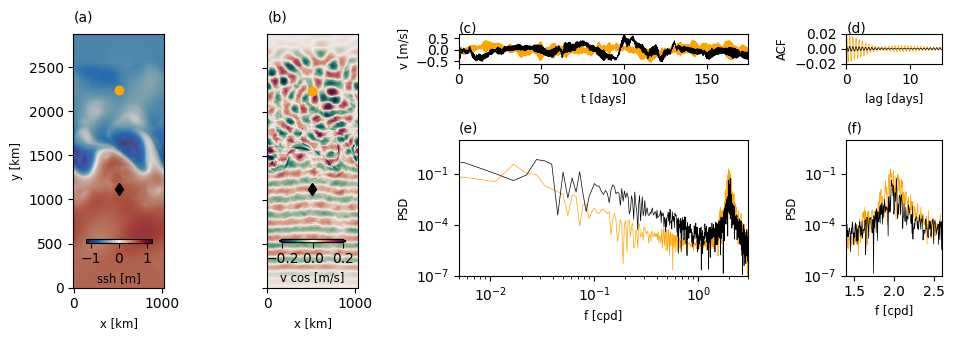

In [222]:
#fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5,8))

fig=plt.figure(figsize=(9.5,3.5))
ax1 = plt.subplot2grid((3,5),(0,0), rowspan=3)
ax2 = plt.subplot2grid((3,5),(0,1), rowspan=3)

fig, ax1, ax2, c1, c2, c3, c4 = initplot(ax1, ax2,tstep=80, )
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][y1],'kd')
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][y2],'orange',marker='o')

ax2.plot(ds_ssh['x'][128], ds_ssh['y'][y1],'kd')
ax2.plot(ds_ssh['x'][128], ds_ssh['y'][y2],'orange',marker='o')
ax2.set_yticklabels([])
ax2.set_ylabel('')


##
ax3 = plt.subplot2grid((3,5),(0,2), colspan=2)
plot_ts(ds_vt.isel(y_vy=1), ax3, c='orange', lw=0.5)
plot_ts(ds_vt.isel(y_vy=0), ax3, c='k', lw=0.5)

ax4 = plt.subplot2grid((3,5),(0,4))
plot_acf(ds_vt.isel(y_vy=1), ax4, c='orange', lw=0.5)
acf, dtout = plot_acf(ds_vt.isel(y_vy=0), ax4, c='k', lw=0.5)

ax5 = plt.subplot2grid((3,5),(1,2), colspan=2, rowspan=2)
plot_psd(ds_vt.isel(y_vy=1), ax5, c='orange', lw=0.5)
plot_psd(ds_vt.isel(y_vy=0), ax5, c='k', lw=0.5)
ax5.set_xlim(5e-3, 3)
# ax.set_xlim(1.4, 2.6)
# ax.set_xscale('linear')
ax5.set_ylim(1e-7, 1e1)

ax6 = plt.subplot2grid((3,5),(1,4), rowspan=2 )
plot_psd(ds_vt.isel(y_vy=1), ax6, c='orange', lw=0.5)
plot_psd(ds_vt.isel(y_vy=0), ax6, c='k', lw=0.5)
# ax.set_xlim(5e-3, 3)
ax6.set_xlim(1.4, 2.6)
ax6.set_xscale('linear')
ax6.set_ylim(1e-7, 1e1)

ax1.set_title('')
ax1.set_xlabel('x [km]')
ax1.set_ylabel('y [km]')
ax2.set_xlabel('x [km]')
ax3.set_title('')
ax3.set_ylabel('v [m/s]')
ax3.set_xlabel('t [days]')
ax3.set_xlim(0,175)

ax4.set_ylabel('ACF')
ax4.set_xlabel('lag [days]')
ax4.set_xlim(0,15)

ax5.set_ylabel('PSD')
ax6.set_ylabel('PSD')
ax5.set_xlabel('f [cpd]')
ax6.set_xlabel('f [cpd]')

ax1.text(0.0,1.05, '(a)', transform=ax1.transAxes)
ax2.text(0.0,1.05, '(b)', transform=ax2.transAxes)
ax3.text(0.0,1.05, '(c)', transform=ax3.transAxes)
ax4.text(0.0,1.05, '(d)', transform=ax4.transAxes)
ax5.text(0.0,1.05, '(e)', transform=ax5.transAxes)
ax6.text(0.0,1.05, '(f)', transform=ax6.transAxes)

plt.tight_layout()

outfile = f'../FIGURES/PK2015_{scenario}_overview.png'
plt.savefig(outfile, dpi=150)
#ax3.set_xticklabels([])
#plt.subplots_adjust(wspace=0.25)